In [3]:
# Imports
import numpy as np
import pandas as pd
import sklearn.metrics as skm
from statsmodels.tsa.vector_ar.var_model import VAR
import statsmodels.tsa.vector_ar.vecm
import statsmodels.api as sm
import seaborn as sns
from matplotlib import pyplot as plt
import openpyxl

In [9]:
# Define your path
path = "/Users/v.d Bosch/Downloads/"

In [333]:
country_list = openpyxl.load_workbook(path + "Country_data.xlsx").sheetnames
df_country = pd.read_excel(path + "Country_data.xlsx",index_col=0, sheet_name=country_list)
country_list = np.array(country_list)

dom_variable_list = np.array(['y','Dp','eq','ep','r','lr'])
variable_list = np.array(['y','Dp','eq','ep','r','lr','ys','Dps','eqs','eps','rs','lrs'])
ext_variable_list = np.array(['Real gross domestic product','Inflation rate','Nominal equity price index','Real exchange rate','Short-term interest rate','Long-term interest rate'])

df_dom = {}
df_for = {}

set_variables = pd.DataFrame(index=variable_list)

for country in country_list:
    df_country[country].index = pd.date_range('1979-04','2020', freq='Q')

    domestic_cols = [col for col in df_country[country].columns if not col.endswith("s")]
    df_dom[country] = df_country[country].loc[:,domestic_cols]
    
    foreign_cols = [col for col in df_country[country].columns if col.endswith("s")]
    df_for[country] = df_country[country].loc[:,foreign_cols]
    
    for variable in variable_list:
        if np.isin(variable, df_country[country].columns):
            set_variables.loc[variable,country] = True
        else:
            set_variables.loc[variable,country] = False

# Plot variables

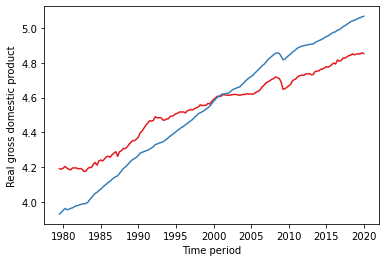

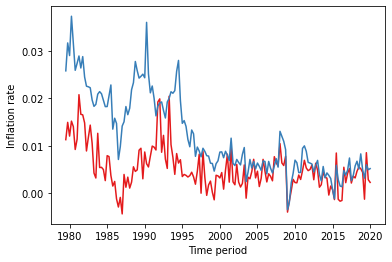

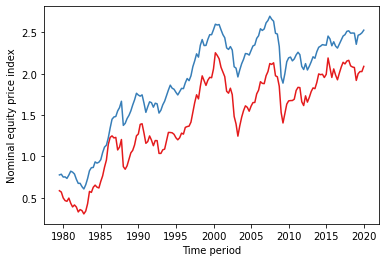

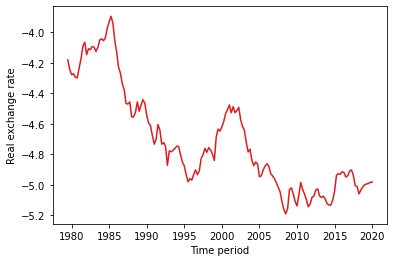

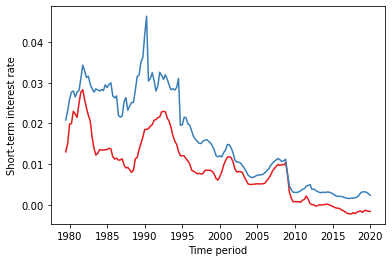

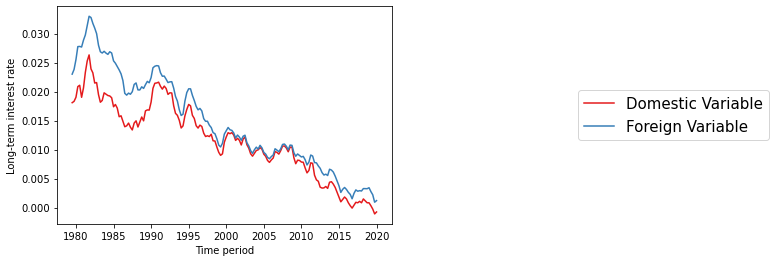

In [334]:
# Define a country
country = 'Germany'

sns.set_palette("Set1")

# Plot x_it and x_star for every variable
for i in range(len(ext_variable_list)-1):
    if set_variables[country][variable_list[i]]:
        plt.plot(df_dom[country][variable_list[i]])
    
    if set_variables[country][variable_list[i]+"s"]:
        plt.plot(df_for[country][variable_list[i]+"s"])
    
    plt.xlabel("Time period")
    plt.ylabel(ext_variable_list[i])
        
    plt.show()


fig, ax = plt.subplots()

sns.lineplot(data=df_dom[country][variable_list[5]],label='Domestic Variable')
sns.lineplot(data=df_for[country][variable_list[5]+"s"],label='Foreign Variable')
    
plt.xlabel("Time period")
plt.ylabel(ext_variable_list[5])
    
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width, pos.height])
ax.legend(loc='center right', bbox_to_anchor=(2.15, 0.5),prop={'size':15})

plt.show()

# Test order of integration

In [264]:
# Define the DataFrames to fill the results in
adf_test_diff0 = pd.DataFrame(index=dom_variable_list)
adf_test_diff1 = pd.DataFrame(index=dom_variable_list)
adf_test_diff2 = pd.DataFrame(index=dom_variable_list)

# Loop over every country and variable
for country in country_list:
    for variable in dom_variable_list:
        if set_variables[country][variable]:
            # Take the data and its first and second difference
            non_dif = df_dom[country][variable]
            first_dif = np.diff(non_dif)
            second_dif = np.diff(first_dif)
        
            # Fill the DataFrames with the adf test statistics
            adf_test_diff0.loc[variable,country] = round(sm.tsa.stattools.adfuller(non_dif, autolag= 'AIC',regression='ct')[1],4)
            adf_test_diff1.loc[variable,country] = round(sm.tsa.stattools.adfuller(first_dif, autolag= 'AIC',regression='ct')[1],4)
            adf_test_diff2.loc[variable,country] = round(sm.tsa.stattools.adfuller(second_dif, autolag= 'AIC',regression='ct')[1],4)

In [199]:
# adf_test_diff0
# adf_test_diff1
# adf_test_diff2

# Determine lag order

In [266]:
max_lag = 8

for country in country_list:
    
    # Define the current lowest BIC value
    min_bic = 1000000
    
    # Loop over all possible combinations
    for lag_x_it in range(1,max_lag+1):
        for lag_x_star in range(1,max_lag+1):
            
            # Initialize a dataframe with the x_star values of lag 0
            df_country = pd.concat([df_for[country]])
            df_country.columns += "_L0"
            
            # Loop over all lag_x_it values to add the lagged values of x_it to df_country
            for lag in range(1,lag_x_it+1):
                lagged_x_it = df_dom[country].shift(lag)
                lagged_x_it.columns += "_L"+str(lag) 
                df_country = pd.concat([df_country,lagged_x_it], axis=1)
            
            # Loop over all lag_x_star values to add the lagged values of x_star to df_country
            for lag in range(1,lag_x_star+1):
                lagged_x_star = df_for[country].shift(lag)
                lagged_x_star.columns += "_L"+str(lag) 
                df_country = pd.concat([df_country,lagged_x_star], axis=1)
    
            # Create and fit the model
            model = VAR(endog = df_dom[country].iloc[max_lag:], exog = df_country.iloc[max_lag:])
            results = model.fit(maxlags=0,trend='ct')
                        
            # Update the lag and BIC value if the BIC value is smaller
            if (results.bic < min_bic):
                min_bic = results.bic
                best_lag_bic = (lag_x_it,lag_x_star)
    
    print("For",country)
    print("The lag order by BIC is",best_lag_bic)
    print("The BIC value is",min_bic)
    print("")

For Argentina
The lag order by BIC is (2, 1)
The BIC value is -23.337819956235293

For Australia
The lag order by BIC is (1, 1)
The BIC value is -57.733511203195626

For Austria
The lag order by BIC is (1, 1)
The BIC value is -60.83426557220619

For Belgium
The lag order by BIC is (1, 1)
The BIC value is -60.587925235562494

For Brazil
The lag order by BIC is (1, 2)
The BIC value is -23.83150251501707

For Canada
The lag order by BIC is (1, 1)
The BIC value is -62.66971079552296

For China
The lag order by BIC is (1, 1)
The BIC value is -37.626616398144954

For Chile
The lag order by BIC is (1, 1)
The BIC value is -36.45281350051648

For Finland
The lag order by BIC is (1, 1)
The BIC value is -43.2240841969497

For France
The lag order by BIC is (1, 1)
The BIC value is -62.64468269270999

For Germany
The lag order by BIC is (1, 1)
The BIC value is -62.4295606405708

For India
The lag order by BIC is (1, 1)
The BIC value is -39.34971583519152

For Indonesia
The lag order by BIC is (3, 1

# Fitting the model

In [335]:
# Define the chosen lag
lag_x_it = 1
lag_x_star = 1
max_lag = max(lag_x_it,lag_x_star)

# Define two dictionaries for the parameter estimates and residuals
df_estimates = {}
resid_dict = {}

# Loop over all countries
for country in country_list:
    
    # Initialize a dataframe with the x_star values of lag 0
    df_country = pd.concat([df_for[country]])
    df_country.columns += "_L0"
            
    # Loop over all lag_x_it values to add the lagged values of x_it to df_country
    for lag in range(1,lag_x_it+1):
        lagged_x_it = df_dom[country].shift(lag)
        lagged_x_it.columns += "_L"+str(lag) 
        df_country = pd.concat([df_country,lagged_x_it], axis=1)
            
    # Loop over all lag_x_star values to add the lagged values of x_star to df_country
    for lag in range(1,lag_x_star+1):
        lagged_x_star = df_for[country].shift(lag)
        lagged_x_star.columns += "_L"+str(lag) 
        df_country = pd.concat([df_country,lagged_x_star], axis=1)

    # Create and fit the model
    model = VAR(endog = df_dom[country].iloc[max_lag:], exog = df_country.iloc[max_lag:])
    results = model.fit(maxlags=0,trend='ct')

    # Fill the parameter estimates of the VARX model in the dictionary
    df_estimates[country] = results.params.T

    # Fill the residuals of the VARX model in the dictionary
    resid_dict[country] = results.resid

In [336]:
df_estimates["Argentina"]

,const,trend,ys_L0,Dps_L0,eqs_L0,rs_L0,lrs_L0,y_L1,Dp_L1,eq_L1,ep_L1,r_L1,ys_L1,Dps_L1,eqs_L1,rs_L1,lrs_L1
y,0.229285,0.000400,0.472997,-0.175724,0.033858,0.109425,-1.714623,0.953273,-0.012281,0.010831,0.005137,-0.010610,-0.471943,0.305955,-0.045985,-0.211001,1.159060
Dp,1.291457,0.004158,-1.167375,-1.754068,0.098854,1.994996,30.245470,0.212135,-0.305123,0.027148,0.210341,1.151972,0.680602,-0.235489,0.051489,0.506688,-17.168819
eq,-11.998889,-0.034419,6.407746,0.003628,1.294704,0.516592,5.349369,-0.202396,0.439604,0.815980,-0.100976,-0.065824,-3.012578,-0.579391,-1.308308,-0.729701,-17.825962
ep,-5.728220,-0.012305,-0.881058,-0.997137,-0.065791,0.763894,44.433096,-0.089784,-0.119734,-0.114554,1.029487,-0.274803,2.459835,-0.814998,0.012954,0.925621,-28.513148
r,-3.097359,-0.009108,-1.956741,-3.532297,0.092914,2.817346,45.541142,0.218837,-0.150378,-0.052125,0.279794,0.188585,2.746651,1.654329,0.043503,-0.285892,-31.521850


# Stack the VARX* models

In [302]:
all_variable_names = np.array([])

for country in country_list:
    for variable in dom_variable_list:
        all_variable_names = np.append(all_variable_names,[str(variable)+"_"+str(country)])

k = len(all_variable_names)
all_variable_names

array(['y_Argentina', 'Dp_Argentina', 'eq_Argentina', 'ep_Argentina',
       'r_Argentina', 'lr_Argentina', 'y_Australia', 'Dp_Australia',
       'eq_Australia', 'ep_Australia', 'r_Australia', 'lr_Australia',
       'y_Austria', 'Dp_Austria', 'eq_Austria', 'ep_Austria', 'r_Austria',
       'lr_Austria', 'y_Belgium', 'Dp_Belgium', 'eq_Belgium',
       'ep_Belgium', 'r_Belgium', 'lr_Belgium', 'y_Brazil', 'Dp_Brazil',
       'eq_Brazil', 'ep_Brazil', 'r_Brazil', 'lr_Brazil', 'y_Canada',
       'Dp_Canada', 'eq_Canada', 'ep_Canada', 'r_Canada', 'lr_Canada',
       'y_China', 'Dp_China', 'eq_China', 'ep_China', 'r_China',
       'lr_China', 'y_Chile', 'Dp_Chile', 'eq_Chile', 'ep_Chile',
       'r_Chile', 'lr_Chile', 'y_Finland', 'Dp_Finland', 'eq_Finland',
       'ep_Finland', 'r_Finland', 'lr_Finland', 'y_France', 'Dp_France',
       'eq_France', 'ep_France', 'r_France', 'lr_France', 'y_Germany',
       'Dp_Germany', 'eq_Germany', 'ep_Germany', 'r_Germany',
       'lr_Germany', 'y_India', 

In [337]:
# Stack all a_i0 parameters
matrix_col = []
for country in country_list:
    matrix_col.append(df_estimates[country].loc[:,"const"])
a_0 = pd.concat(matrix_col)

# Stack all a_i1 parameters
matrix_col = []

for country in country_list:
    matrix_col.append(df_estimates[country].loc[:,"trend"])
a_1 = pd.concat(matrix_col)

# Stack all residuals
epsilon_t = pd.concat(resid_dict.values(), axis=1).T

In [368]:
def create_G_j(j):
    
    # Define an empty collection of matrices
    matrix_col = []

    # Loop over all countries
    for country in country_list:
        
        current_dom_variables = np.array(dom_variable_list)[set_variables.loc[dom_variable_list][country].tolist()]
        k_i = len(current_dom_variables)
        
        # Create Omega_i
        E_i = np.zeros((k_i,k))
        
        for k_i_count in range(k_i):
            i = np.where(all_variable_names == (str(dom_variable_list[j])+"_"+str(country)))[0][0]
            E_i[k_i_count][i] = 1
        
        W_i = np.hstack([foreign_trade * np.eye(k_star) for foreign_trade in df_trade.loc[country]])
        Omega_i = np.vstack((E_i,W_i))
        
        # Create A_ij, depending on j
        if (j == 0):
            selected_cols = [col for col in df_estimates[country].columns if col.endswith("x_star_L0")]
            
            lambda_i = df_estimates[country].loc[:,selected_cols]
            A_i = np.hstack((np.eye(k_i),-lambda_i))
        else:
            
            if (lag_x_it < j):
                phi_i = np.zeros((k_i,k_i))
            else:
                selected_cols = [col for col in df_estimates[country].columns if col.endswith("x_it_L"+str(j))]
                phi_i = df_estimates[country].loc[:,selected_cols]
                
            if (lag_x_star < j):
                lambda_i = np.zeros((k_i,k_star))
            else:
                selected_cols = [col for col in df_estimates[country].columns if col.endswith("x_star_L"+str(j))]
                lambda_i = df_estimates[country].loc[:,selected_cols]
                
            A_i = np.hstack((phi_i,lambda_i))
        
        # Finally, compute G_i by A_i and Omega_i
        G_i = A_i @ Omega_i
        matrix_col.append(G_i)

    # Return G_j
    return np.vstack(matrix_col)

In [347]:
np.array(dom_variable_list)[set_variables.loc[dom_variable_list][country].tolist()]

array(['y', 'Dp', 'eq', 'r', 'lr'], dtype='<U2')